In [30]:
import os

input_dir = "./images/"
target_dir = "annotations/trimaps"

img_size = (160, 160)
num_classes = 3
batch_size = 32

print(os.listdir(input_dir))

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

target_img_paths = sorted(
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")
)

print("samples: " + str(len(input_img_paths)))

for input_img_path, target_img_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_img_path, " | ", target_img_path)


['Abyssinian_1.jpg', 'Abyssinian_10.jpg', 'Abyssinian_100.jpg', 'Abyssinian_100.mat', 'Abyssinian_101.jpg', 'Abyssinian_101.mat', 'Abyssinian_102.jpg', 'Abyssinian_102.mat', 'Abyssinian_103.jpg', 'Abyssinian_104.jpg', 'Abyssinian_105.jpg', 'Abyssinian_106.jpg', 'Abyssinian_107.jpg', 'Abyssinian_108.jpg', 'Abyssinian_109.jpg', 'Abyssinian_11.jpg', 'Abyssinian_110.jpg', 'Abyssinian_111.jpg', 'Abyssinian_112.jpg', 'Abyssinian_113.jpg', 'Abyssinian_114.jpg', 'Abyssinian_115.jpg', 'Abyssinian_116.jpg', 'Abyssinian_117.jpg', 'Abyssinian_118.jpg', 'Abyssinian_119.jpg', 'Abyssinian_12.jpg', 'Abyssinian_120.jpg', 'Abyssinian_121.jpg', 'Abyssinian_122.jpg', 'Abyssinian_123.jpg', 'Abyssinian_124.jpg', 'Abyssinian_125.jpg', 'Abyssinian_126.jpg', 'Abyssinian_127.jpg', 'Abyssinian_128.jpg', 'Abyssinian_129.jpg', 'Abyssinian_13.jpg', 'Abyssinian_130.jpg', 'Abyssinian_131.jpg', 'Abyssinian_132.jpg', 'Abyssinian_133.jpg', 'Abyssinian_134.jpg', 'Abyssinian_135.jpg', 'Abyssinian_136.jpg', 'Abyssinian_137

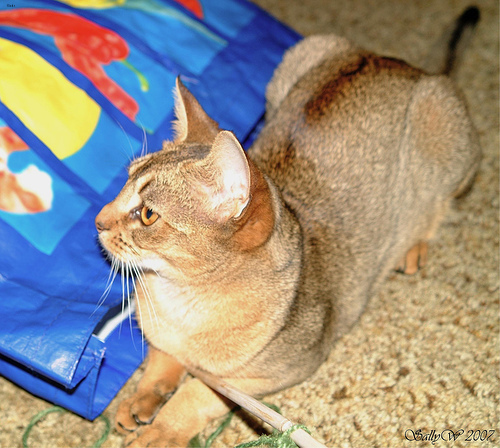

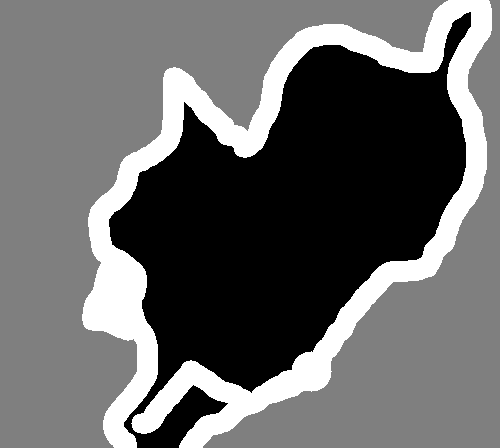

In [19]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

display(Image(filename=input_img_paths[9]))
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [20]:
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import data as tf_image

from tensorflow import io as tf_io

def get_dataset(
        batch_size,
        img_size,
        input_img_paths,
        target_img_paths,
        max_dataset_len=None
):
    def load_img_masks(input_img_paths, target_img_paths):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.conver_image_dytpe(target_img, "uint8")

        target_img -= 1

        return input_img, target_img

    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_path = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))

    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)

    return dataset.batch(batch_size)

In [27]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = layers.Input(shape=img_size+(3, ))

    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x

    for filters in [64, 128, 256]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)


        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(filters, 1, strides=2, padding='same')(previous_block_activation)

        x = layers.add([x, residual])

        previous_block_activation = x

    for filters in [256, 128, 64, 32]:
        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding='same')(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    output = layers.Conv2DTranspose(num_classes, 3, activation="softmax", padding='same')(x)

    model = keras.Model(inputs=inputs, outputs=output)
    return model

model = get_model(image_size, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 80, 80,    │        896 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 80, 80,    │          0 │ activation_18[0]… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_9  │ (None, 80, 80,    │      2,400 │ activation_19[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 40, 40,    │      2,112 │ activation_18[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 40, 40,    │          0 │ max_pooling2d_9[… │
│                     │ 64)               │            │ conv2d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 40, 40,    │          0 │ add_10[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_10 │ (None, 40, 40,    │      8,896 │ activation_20[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 20, 20,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 20, 20,    │      8,320 │ add_10[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 20, 20,    │          0 │ max_pooling2d_10… │
│                     │ 128)              │            │ conv2d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 20, 20,    │          0 │ add_11[0][0]    

 Total params: 1,966,691 (7.50 MB)

 Trainable params: 1,963,811 (7.49 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [1]:
import random

val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=1000
)

val_dataset = get_dataset(
    batch_size, image_size,
    val_input_img_paths,
    val_target_img_paths,
)

NameError: name 'input_img_paths' is not defined